In [1]:
import cv2
import numpy as np
from vietocr.tool.config import Cfg
from vietocr.tool.predictor import Predictor
import torch 
import torch.nn as nn
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from pyvi import ViTokenizer, ViPosTagger

from spell_checker_module import CustomSpellChecker, spell_check_ocr_result

config for model VietOCR, set weightm cuda and set pretrained model to false


In [2]:
config = Cfg.load_config_from_name('vgg_transformer')
config['weights'] = "D:/DAT_FInal Project/transformerocr.pth" # Update with your VietOCR weights path
config['device'] = 'cuda'  # or 'cpu'
config['cnn']['pretrained'] = False
detector = Predictor(config)

# Initialize EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

c:\Users\bocua\anaconda3\envs\yaocr\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Make sure the ratio image when OCR not bigger than in the root image

In [3]:
def assureRatio(img):
    """Ensure imgH <= imgW."""
    img_tensor = torch.tensor(np.array(img).transpose(2, 0, 1)).unsqueeze(0)  # Add batch dimension
    b, c, h, w = img_tensor.size()
    if h > w:
        main = nn.UpsamplingBilinear2d(size=(h, h))
        img_tensor = main(img_tensor)
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension
    img = Image.fromarray(img_tensor.numpy().transpose(1, 2, 0).astype('uint8'))
    return img

SPell checker for spelling problems

In [4]:
spell_checker = CustomSpellChecker('D:\DAT_FInal Project\extracted_vn_words.txt')

In [5]:
def add_padding(image, target_size):
    h, w = image.shape[:2]
    if h >= target_size and w >= target_size:
        return image, 0, 0
    
    top = (target_size - h) // 2 if h < target_size else 0
    bottom = (target_size - h + 1) // 2 if h < target_size else 0
    left = (target_size - w) // 2 if w < target_size else 0
    right = (target_size - w + 1) // 2 if w < target_size else 0
    
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image, top, left


In [6]:
HORIZONTAL_THRESHOLD= 450
VERTICAL_THRESHOLD= 5
MAX_HORIZONTAL_GAP= 500

Preprocess image for the detection process


In [7]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image at path: {image_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Convert back to BGR
    processed_image = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    
    return processed_image

def detect_text_regions(image_path, target_size=640):
    # Preprocess image
    image = preprocess_image(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Resize the image to the target size
    image = cv2.resize(image, (target_size, target_size))
    rW = W / float(target_size)
    rH = H / float(target_size)

    print(f"Resized image to: {image.shape}")

    # Define the layer names that we are interested in
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Construct a blob from the image and then perform a forward pass of the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (target_size, target_size), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    print("Forward pass of EAST model complete")

    # Decode the predictions, then apply non-maxima suppression to suppress weak, overlapping bounding boxes
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Merge horizontally aligned boxes
    # Merge horizontally aligned boxes with refined thresholds
    boxes = merge_horizontal_boxes(boxes, #horizontal_threshold= HORIZONTAL_THRESHOLD, 
                                   vertical_threshold=VERTICAL_THRESHOLD, 
                                   max_horizontal_gap= MAX_HORIZONTAL_GAP)


    # Initialize the list of results
    results = []

    # Loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # Scale the bounding box coordinates based on the respective ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # Update our results list to consist of the bounding box coordinates
        results.append((startX, startY, endX, endY))

    # Draw bounding boxes on the original image for visualization
    for (startX, startY, endX, endY) in results:
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title('Detected Text Regions')
    plt.axis('off')
    plt.show()
    
    return results, orig

def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.4):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")



def merge_horizontal_boxes(boxes, max_horizontal_gap= MAX_HORIZONTAL_GAP, 
                           vertical_threshold= VERTICAL_THRESHOLD):
    if len(boxes) <= 1:
        return boxes

    merged_boxes = []
    boxes = sorted(boxes, key=lambda x: (x[1], x[0]))  # Sort boxes by y and then x coordinate

    current_box = boxes[0]
    for box in boxes[1:]:
        # Calculate horizontal and vertical distances
        horizontal_distance = box[0] - current_box[2]
        vertical_distance_top = abs(box[1] - current_box[1])
        vertical_distance_bottom = abs(box[3] - current_box[3])
        
        # Check if boxes are close enough horizontally and aligned vertically
        if horizontal_distance <= max_horizontal_gap and (vertical_distance_top <= vertical_threshold or vertical_distance_bottom <= vertical_threshold):
            # Merge boxes if they are horizontally close and vertically aligned
            current_box = (min(current_box[0], box[0]), 
                           min(current_box[1], box[1]), 
                           max(current_box[2], box[2]), 
                           max(current_box[3], box[3]))
        else:
            merged_boxes.append(current_box)
            current_box = box

    merged_boxes.append(current_box)
    return merged_boxes

def crop_text_regions(image, text_regions):
    crops = []
    for (startX, startY, endX, endY) in text_regions:
        crop = image[startY:endY, startX:endX]
        crops.append(crop)
    return crops

In [11]:
def detect_tables(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orig_image = cv2.imread(image_path)

    # Threshold the image
    _, binary = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)

    # Detect horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # Detect vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Combine the horizontal and vertical lines
    table_structure = cv2.add(detect_horizontal, detect_vertical)

    # Find contours
    contours, _ = cv2.findContours(table_structure, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes for detected tables
    table_bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        table_bounding_boxes.append((x, y, x + w, y + h))
        cv2.rectangle(orig_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return table_bounding_boxes

OCR Process

In [12]:

def recognize_text_vietocr(crops):
    recognized_texts = []
    for crop in crops:
        pil_image = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        text = detector.predict(pil_image)
        recognized_texts.append(text)
    return recognized_texts


def draw_boxes(image, text_regions, recognized_texts):
    for (text, (startX, startY, endX, endY)) in zip(recognized_texts, text_regions):
        # Draw the bounding box
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 1)
        
        # Put the recognized text above the bounding box
        cv2.putText(image, text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return image


Resized image to: (640, 640, 3)
Forward pass of EAST model complete


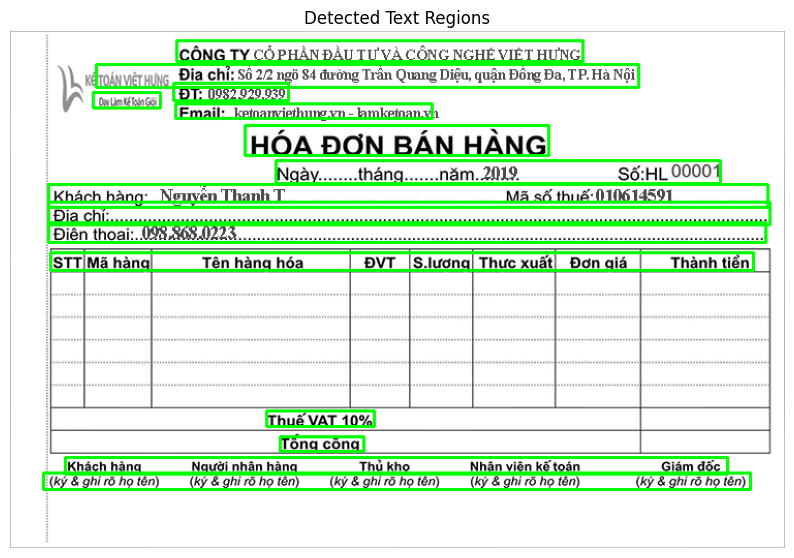

Region 1 Coordinates: StartX: 161, StartY: 9, EndX: 554, EndY: 29
Region 1 Corrected Text: CỘNG TY CỎ PHẦN ĐẦU TƯ VÀ CỘNG NGHỆ VIẾT HƯNG


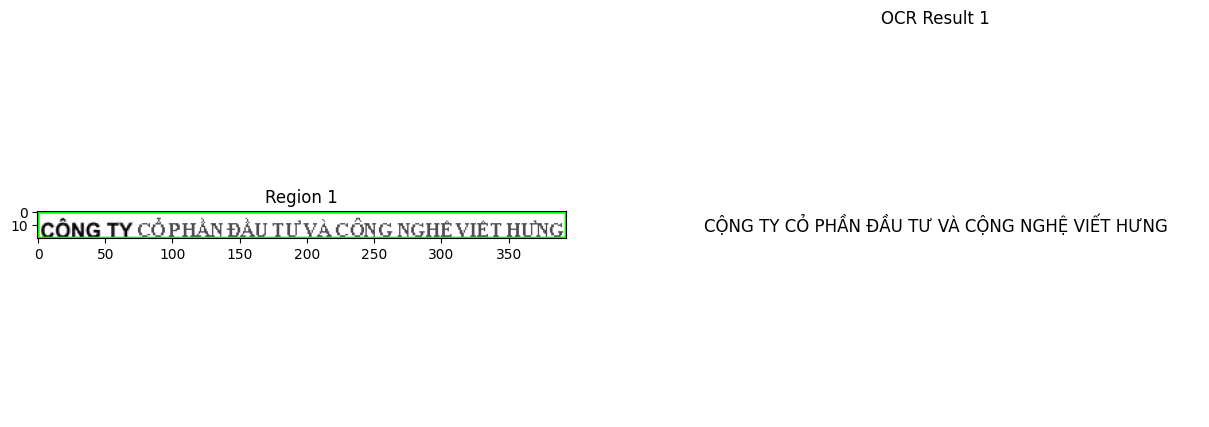

Region 2 Coordinates: StartX: 83, StartY: 32, EndX: 608, EndY: 54
Region 2 Corrected Text: ToánViệT Hứng Địa chỉ: Số 222 ngõ S4 đường Trần Quang Diệu, quận Đống Đa, TP.Hà Nội


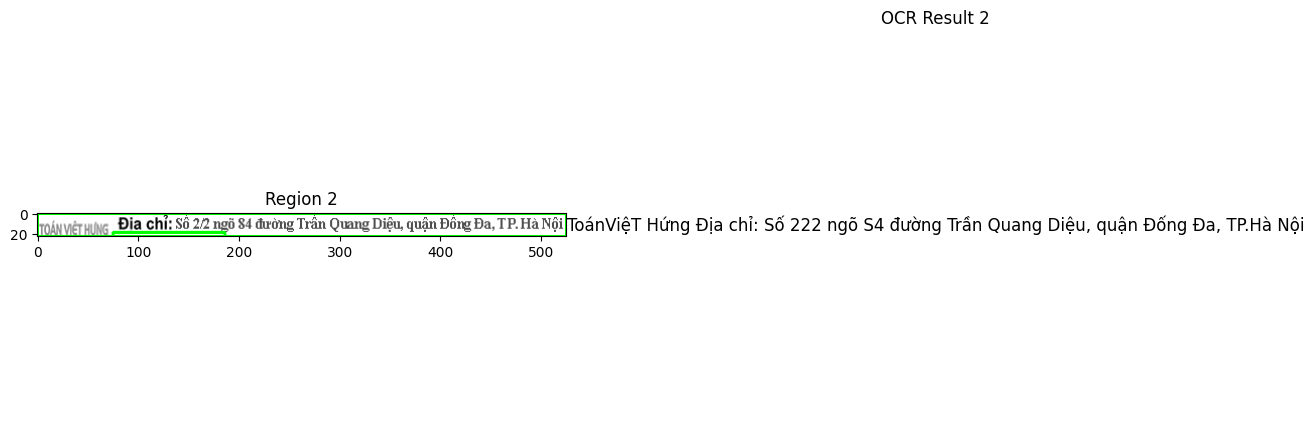

Region 3 Coordinates: StartX: 158, StartY: 50, EndX: 269, EndY: 67
Region 3 Corrected Text: ĐTA 0982020 030


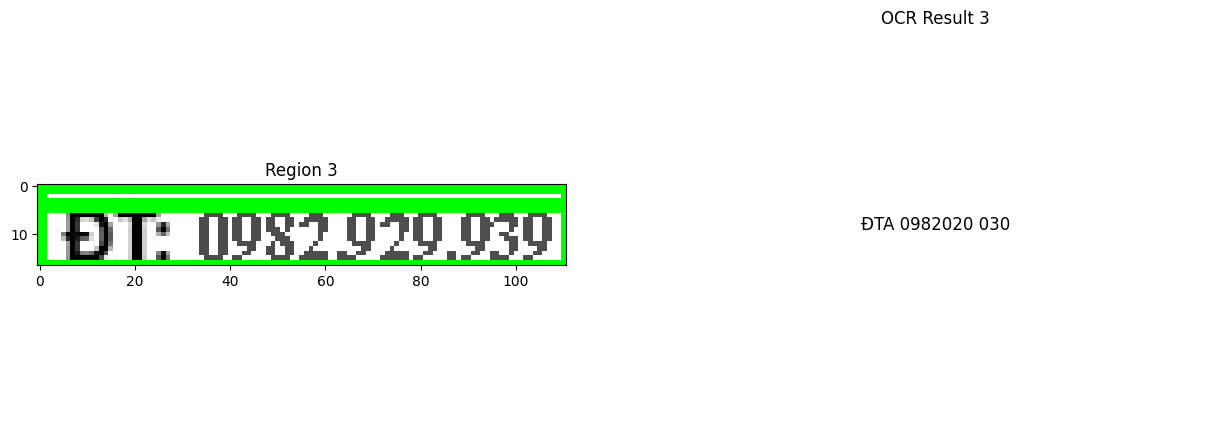

Region 4 Coordinates: StartX: 80, StartY: 59, EndX: 145, EndY: 74
Region 4 Corrected Text: Đay Lâm Kê Toán Gồi


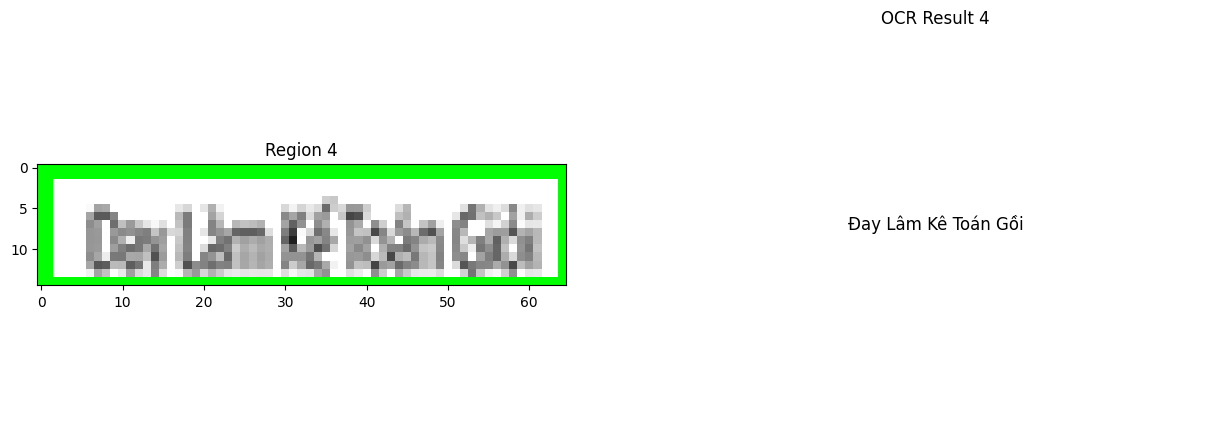

Region 5 Coordinates: StartX: 160, StartY: 70, EndX: 408, EndY: 84
Region 5 Corrected Text: Email: ketoanviethunơ 10 - lam ketnan


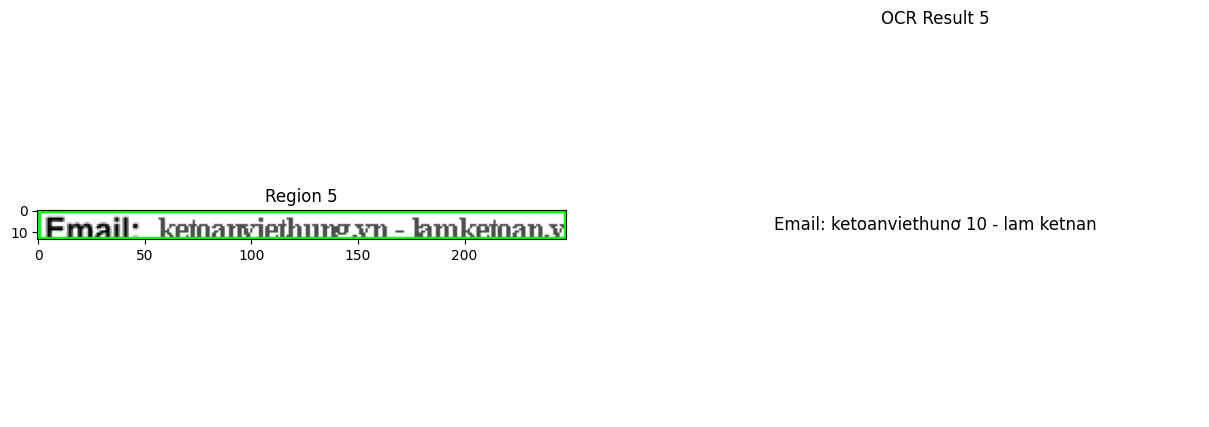

Region 6 Coordinates: StartX: 227, StartY: 91, EndX: 521, EndY: 120
Region 6 Corrected Text: HOA ĐƠN BÁN HÀNG


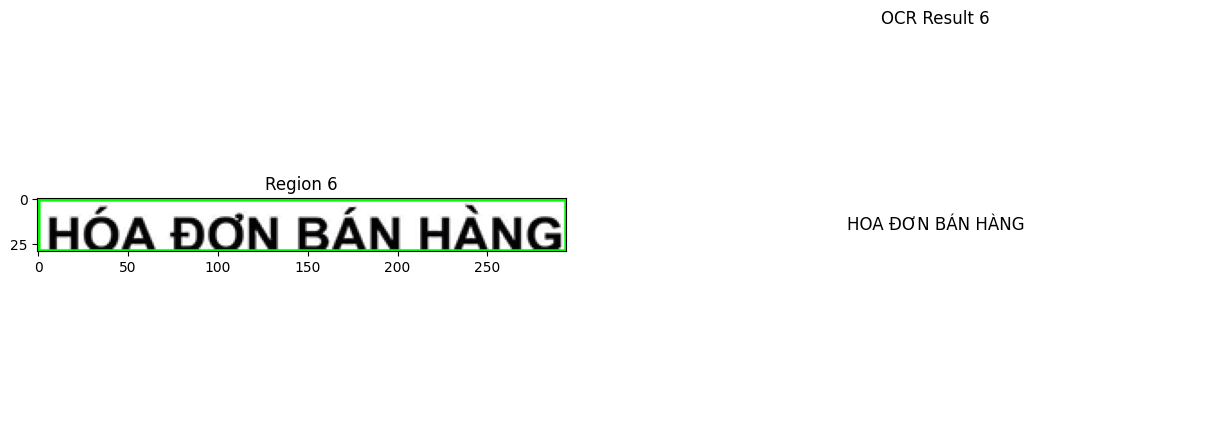

Region 7 Coordinates: StartX: 257, StartY: 125, EndX: 687, EndY: 147
Region 7 Corrected Text: Ngày: tháng : năm 2019


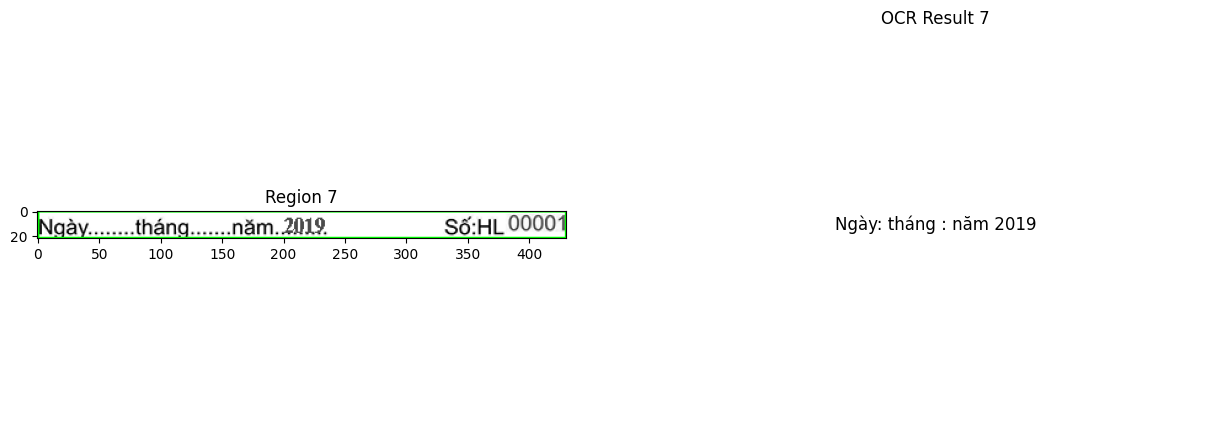

Region 8 Coordinates: StartX: 37, StartY: 148, EndX: 733, EndY: 170
Region 8 Corrected Text: Khách hàng: Nguyễn Thanh T


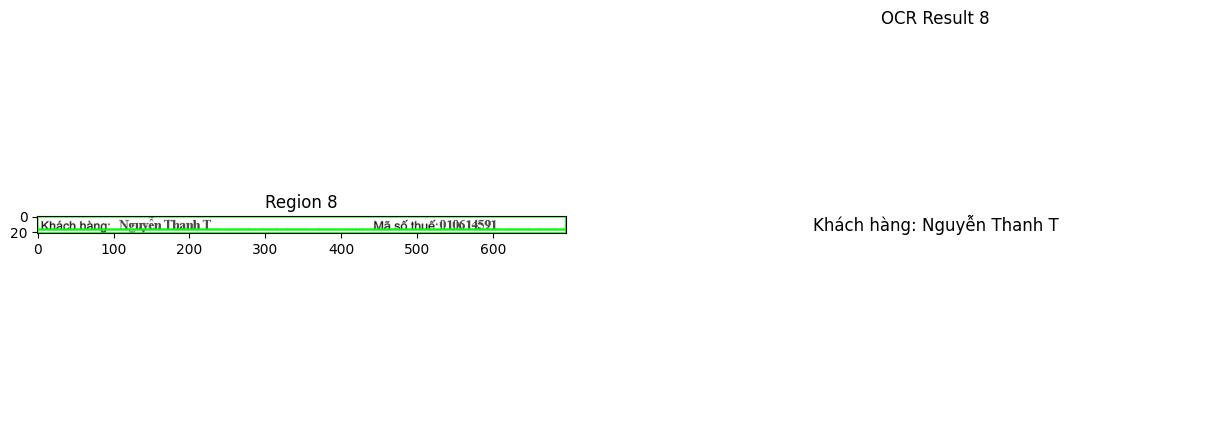

Region 9 Coordinates: StartX: 37, StartY: 165, EndX: 735, EndY: 187
Region 9 Corrected Text: Địa chỉ chỉ chỉ chỉ cẩm cẩm cả đã cả cả chỉ cả cả chỉ chỉ chỉ chỉ của chỉ chỉ chỉ của chỉ chỉ chỉ chỉ chỉ chỉ chỉ chỉ chỉ chỉ chỉ


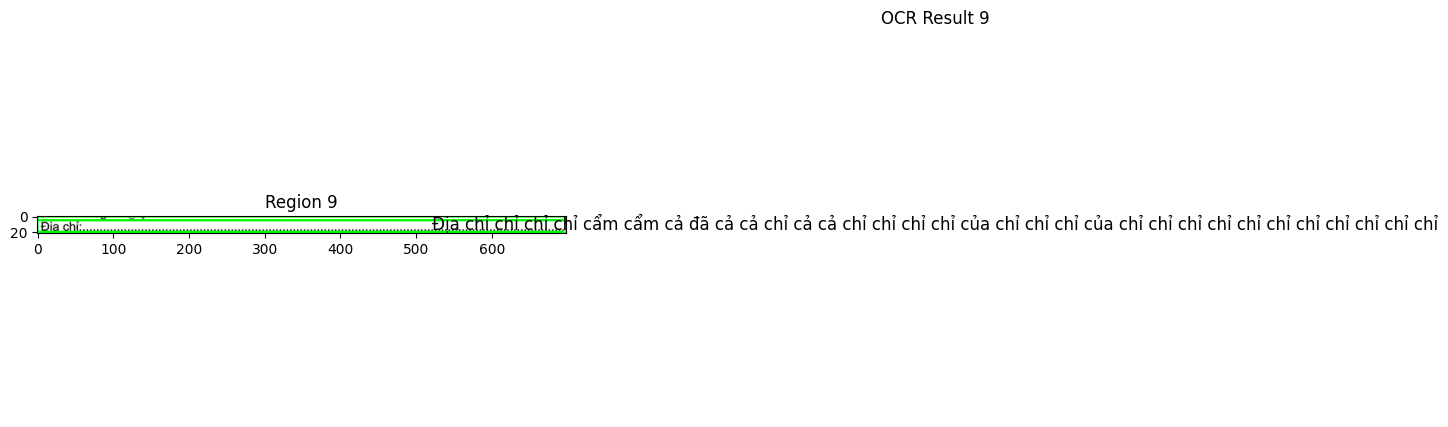

Region 10 Coordinates: StartX: 37, StartY: 185, EndX: 731, EndY: 204
Region 10 Corrected Text: Điền thoan 028:08/022 108/080


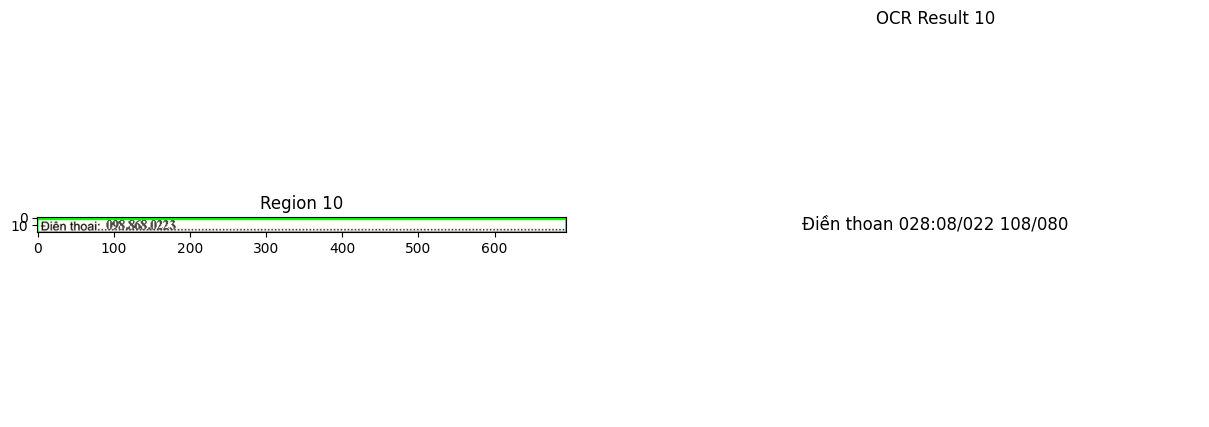

Region 11 Coordinates: StartX: 39, StartY: 214, EndX: 719, EndY: 231
Region 11 Corrected Text: STT Mã hàng Tên hàng hóa ĐVT Slương Thực xuất Đơn giá


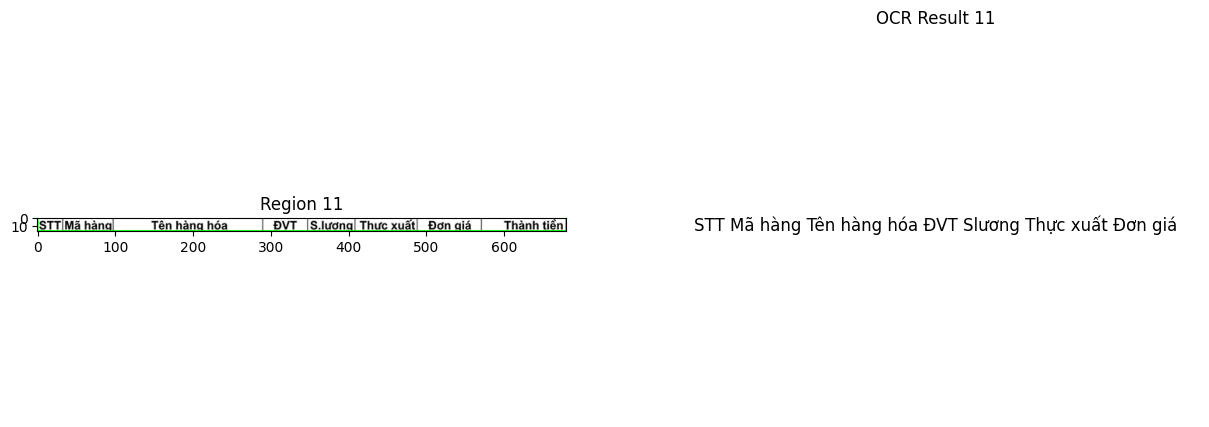

Region 12 Coordinates: StartX: 248, StartY: 367, EndX: 352, EndY: 382
Region 12 Corrected Text: Thuế VAT 10+


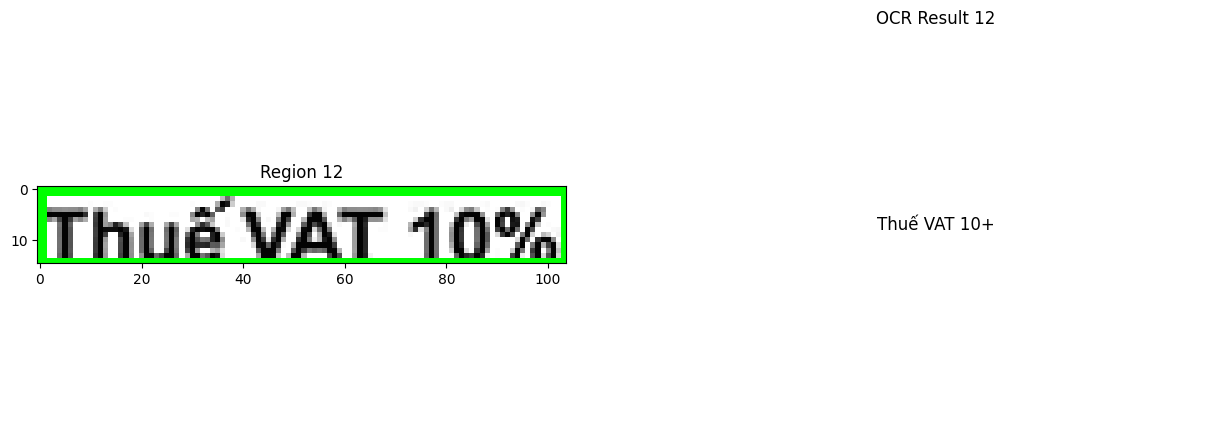

Region 13 Coordinates: StartX: 261, StartY: 392, EndX: 342, EndY: 406
Region 13 Corrected Text: Tổng cộng


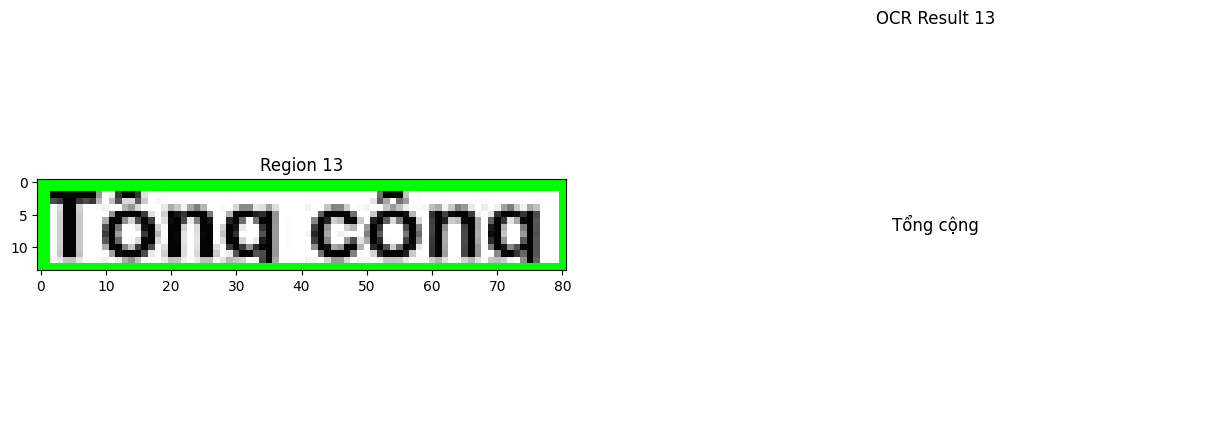

Region 14 Coordinates: StartX: 53, StartY: 412, EndX: 694, EndY: 428
Region 14 Corrected Text: Khách hàng Thu kho Nhân viên kế toán


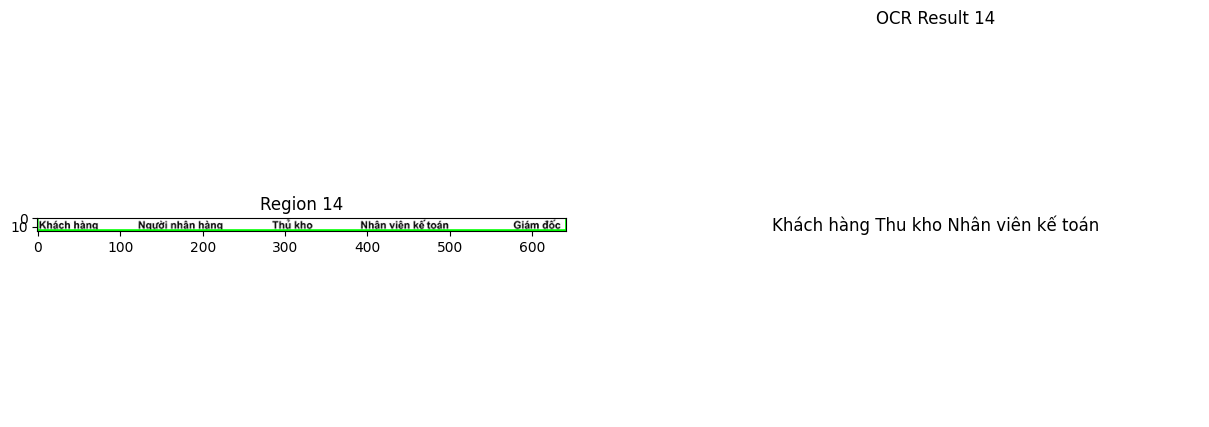

Region 15 Coordinates: StartX: 32, StartY: 427, EndX: 716, EndY: 443
Region 15 Corrected Text: VM chỉ rõ họ tên) (Wa phú rõ họ tân) (Kỳ  8.ghỉ rõ họ tên (Kỳ đ, ghi rõ họ tên)


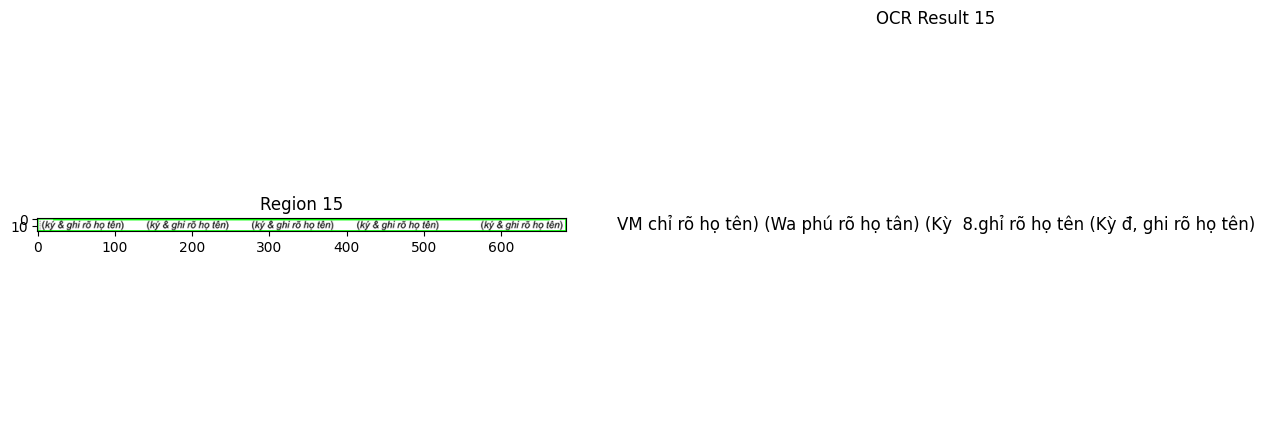

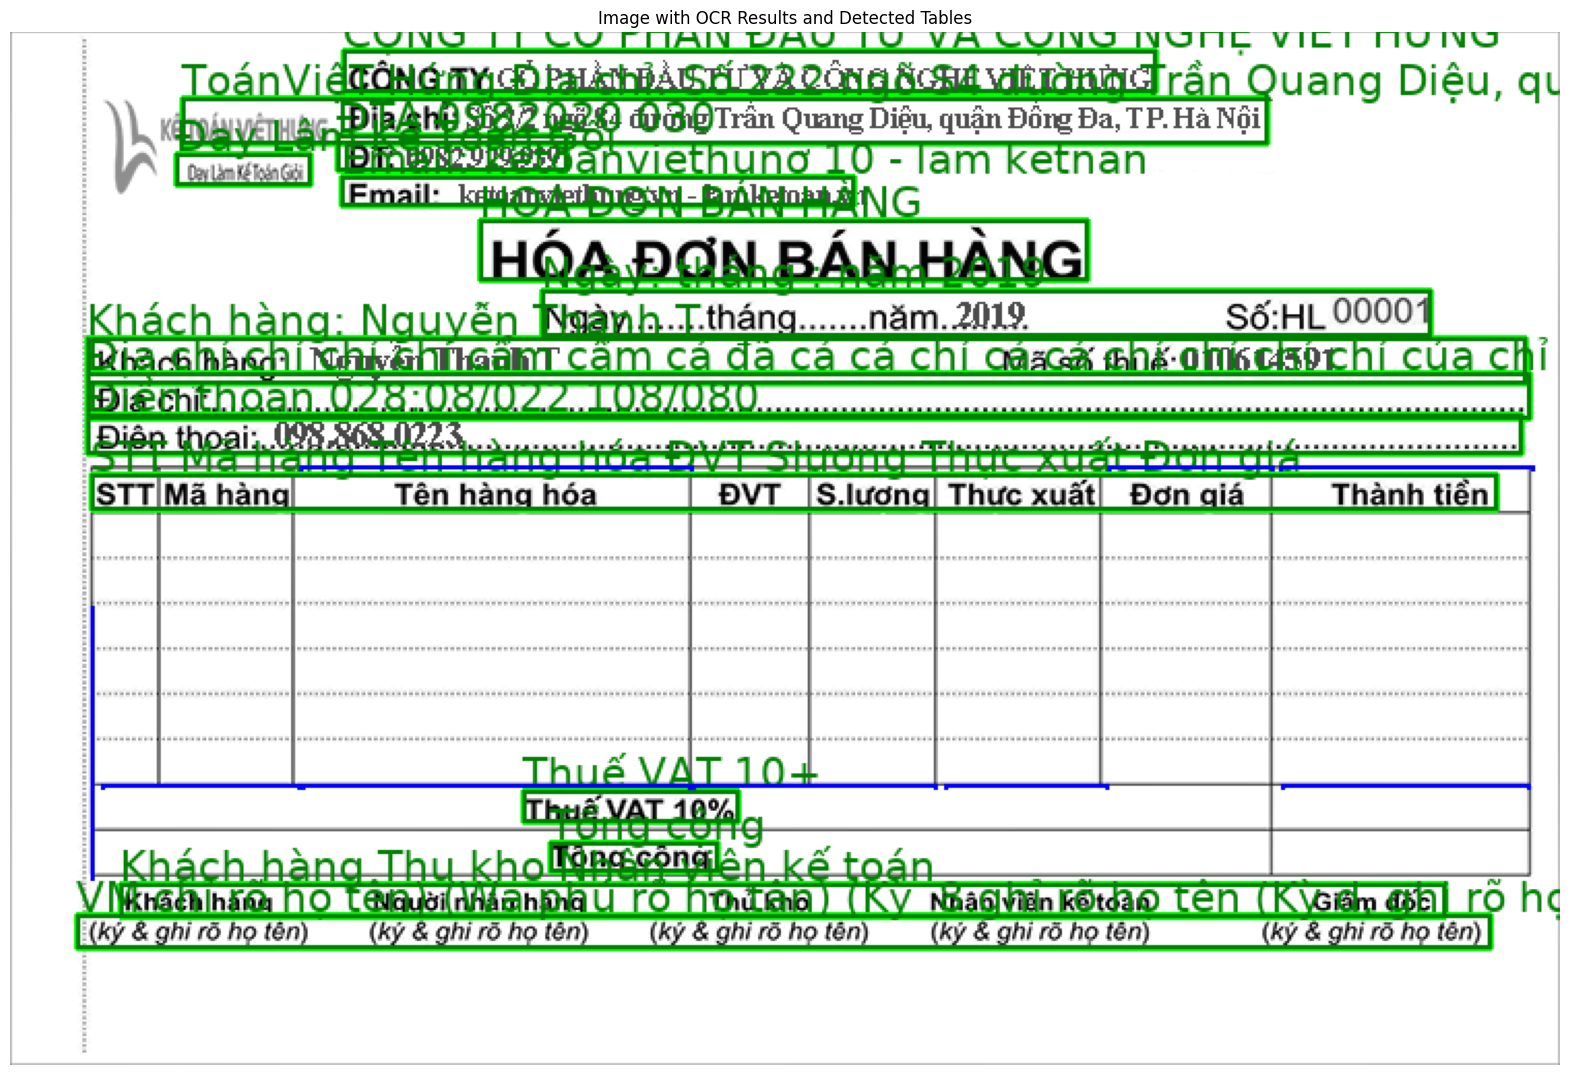

In [13]:
def main(image_path):
    try:
        # Detect text regions and tables
        text_regions, image = detect_text_regions(image_path)
        table_bounding_boxes = detect_tables(image_path)

        # Crop text regions
        crops = crop_text_regions(image, text_regions)
        recognized_texts = recognize_text_vietocr(crops)
    except Exception as e:
        print(f"Error processing image: {e}")
        return

    font_path = 'DejaVuSans.ttf'  # Ensure this path points to your font file
    try:
        font = ImageFont.truetype(font_path, 20)
    except IOError:
        print("Font not found. Using default font.")
        font = ImageFont.load_default()

    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    for i, (text, (startX, startY, endX, endY)) in enumerate(zip(recognized_texts, text_regions)):
        print(f"Region {i+1} Coordinates: StartX: {startX}, StartY: {startY}, EndX: {endX}, EndY: {endY}")
        print(f"Region {i+1} Corrected Text: {text}")
        
        plt.figure(figsize=(15, 5))
        
        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image[startY:endY, startX:endX], cv2.COLOR_BGR2RGB))
        plt.title(f'Region {i+1}')
        
        # Display the OCR result
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, text, horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title(f'OCR Result {i+1}')
        plt.axis('off')
        plt.show()

        # Draw bounding box and text on the PIL image
        draw.rectangle([startX, startY, endX, endY], outline="green", width=2)
        draw.text((startX, startY - 20), text, fill="green", font=font)

    # Draw table bounding boxes
    for (x, y, x2, y2) in table_bounding_boxes:
        draw.rectangle([x, y, x2, y2], outline="blue", width=2)

    # Convert the PIL image back to OpenCV format
    image_with_boxes = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Display the image with bounding boxes and text
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title('Image with OCR Results and Detected Tables')
    plt.axis('off')
    plt.show()

# Update with your image path
image_path = '449049065_796066648986894_138736058439049476_n.png'
main(image_path)